# Navigating StyleGAN2 𝑊 latent space using CLIP

A playbook implementing [this repo](https://github.com/l4rz/stylegan2-clip-approach). Basically, it picks a point in 𝑊 space (derived from 𝑧 seed and ψ value) and descends on a new 𝑤 using a loss function based on computing torch.cosine_similarity() between CLIP text and image features. Attempts were made to minimize undesirable distortions of the original image feature during the descent.

This is a rather skeletonized, proof of concept, version. Awesome stuff like saving/loading `.npz` files with 𝑤 values might be added later.

## Acknowledgements

The idea to optimize noise inputs was borrowed from the OG SG2 projector. Also thx to lucidrains for [BigSleep](https://github.com/lucidrains/big-sleep).

## Written by

[l4rz](https://twitter.com/l4rz)


# Quick start

- Enter CLIP text prompt in a cell below, e.g. an image of a man resembling Tom Cruise
- Specify the seed value of an initial image generated by SG2 in Various parameters cell
- Run cells one by one
  + 'Test SG2' generates a sample using SG2 `generate.py` and displays it
  + 'Run the approach' actually starts it. You should observe sth like 

      `step    1/50:  loss 508.18  lr 0.02 noise scale: 0.040000 proximity: 0.238159`

      loss should decrease, proximity should increase

  + 'Display the results' displays the final image and the intepolation video

- Subsequent runs
  + 'CLIP text prompt'
  + 'Run the approach'
  + 'Display the results'

- To use the different pretrained network PKL, edit the url and file name in 'Download the network PKL' cell. E.g. for CAT, uncomment the last two lines.

## Things to try

- seed 1, prompts 
  + 'a high quality image of a young man' 
  + 'an image of a man resembling Tom Cruise'
  + 'an image of a man resembling a frog'
- seed 32, prompt 'an image of an Instagram influencer girl' 
- seed 154, prompt 'an image of a man resembling a vampire, with a face of 
Count Dracula'
- for CAT network, seed 21, prompt 'an image of a black cat'

Increase the `initial_noise_factor` parameter (and maybe `initial_learning_rate`, `noise_floor`) for more dramatic results.




# CLIP text prompt and seed values

In [1]:
text = "a picture of a man with food on his face"
seed =  1

# Various parameters

In [2]:
# Image seed to pass to generator
# Some values for FFHQ network:
#   1: a generic aged man
#   32: a generic woman
# seed = 32

# Number of steps to run
num_steps = 100
# You can tinker with these later
psi = 0.8
initial_learning_rate = 0.02
initial_noise_factor = 0.04 # 0.02 originally
noise_floor = 0.02
# If noise_opt is true then we're optimizing w and noise vars (default behaviour)
noise_opt = True




# Install pytorch

# Clone repos, install useful warez

In [8]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
cd CLIP
cp -r clip ../stylegan2-ada-pytorch stylegan2-ada-pytorch
ls
!apt install -y -q ninja-build 
!pip3 install ftfy


fy



SyntaxError: invalid syntax (<ipython-input-8-685de7a3f1a5>, line 2)

# Download the network PKL





In [ ]:
!rm style*.pkl
# for SG2 FFHQ (human faces):
!wget https://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
network_pkl = 'stylegan2-ffhq-config-f.pkl'

# for SG2 CAT:
#!wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-cat-config-f.pkl
#network_pkl = 'stylegan2-cat-config-f.pkl'

rm: cannot remove 'style*.pkl': No such file or directory
--2021-03-05 14:33:26--  https://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 52.84.90.56, 52.84.90.176, 52.84.90.219, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|52.84.90.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   213MB/s    in 1.7s    

2021-03-05 14:33:29 (213 MB/s) - ‘stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]

--2021-03-05 14:33:29--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-cat-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 52.84.90.56, 52.84.90.176, 52.84.90.219, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti

# Test SG2

Loading networks from "stylegan2-ffhq-config-f.pkl"...
Generating image for seed 1 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


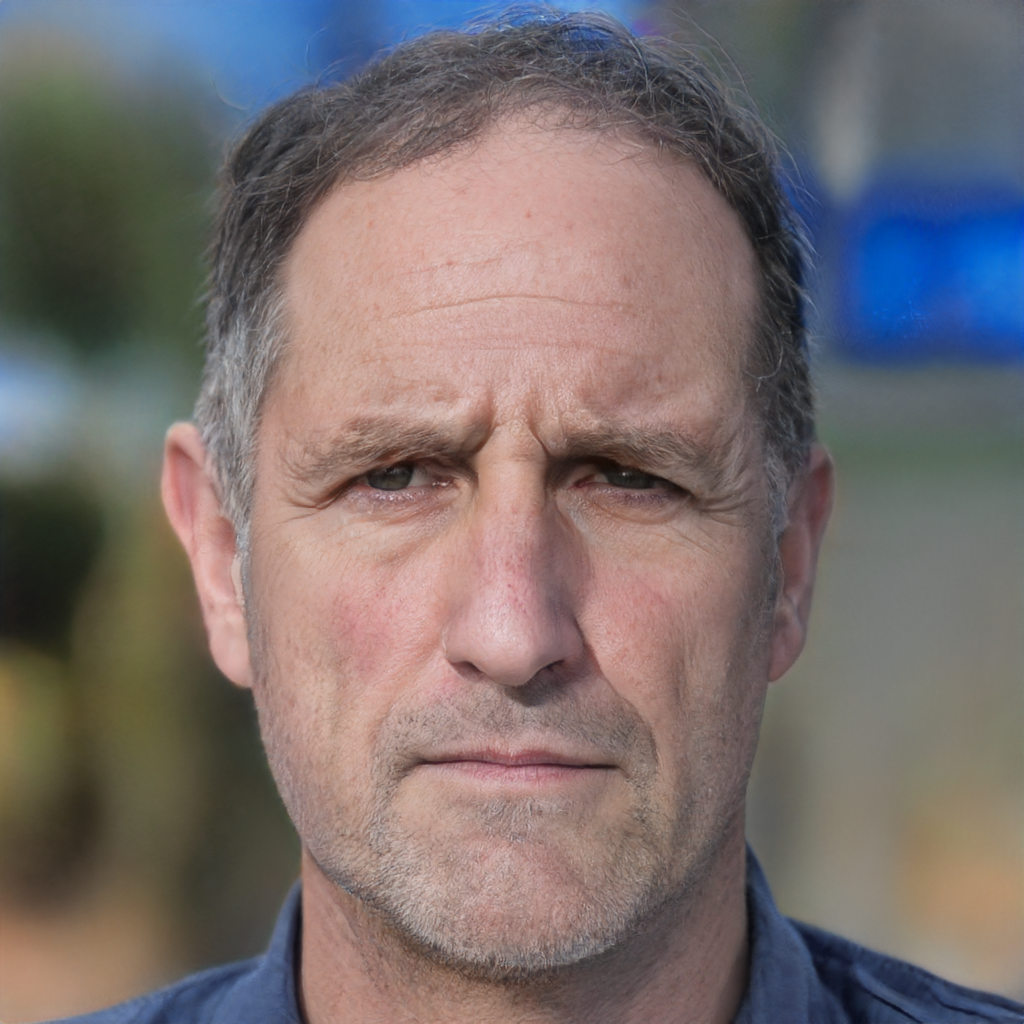

In [ ]:
!python3 generate.py --seeds 1 --network stylegan2-ffhq-config-f.pkl --outdir results

from IPython.display import Image, display
# re do it in a nice way
display(Image('results/seed0001.png',width=512,height=512))



# Initialize the approach routine


In [ ]:
import copy
import os
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torchvision
import torch.nn.functional as F
import dnnlib
import legacy
import clip


def approach(
    G,
    *,
    num_steps                  = 100,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.02,  
    initial_noise_factor       = 0.02,  
    noise_floor                = 0.02, 
    psi                        = 0.8,
    noise_ramp_length          = 1.0, # was 0.75
    regularize_noise_weight    = 10000, # was 1e5
    seed                       = 69097, 
    noise_opt                  = True, 
    ws                         = None,
    text                       = 'a computer generated image', 
    device: torch.device
):

    '''
    local_args = dict(locals())
    params = []
    for x in local_args:
        if x != 'G' and x != 'device':
            print(x,':',local_args[x])
            params.append({x:local_args[x]})
    print(json.dumps(params))
    '''

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device)

    lr = initial_learning_rate

    '''
    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    #w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device),  None, truncation_psi=0.8)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
    '''

    # derive W from seed
    if ws is None:
        print('Generating w for seed %i' % seed )
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
        w_samples = G.mapping(z,  None, truncation_psi=psi)
        w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
        w_avg = np.mean(w_samples, axis=0, keepdims=True)
    else:
        w_samples = torch.tensor(ws, device=device)
        w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
        w_avg = np.mean(w_samples, axis=0, keepdims=True)
    #w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
    w_std = 2 # ~9.9 for portraits network. should compute if using median median

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)

    if noise_opt:
        optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
        print('optimizer: w + noise')
    else:
        optimizer = torch.optim.Adam([w_opt] , betas=(0.9, 0.999), lr=initial_learning_rate)
        print('optimizer: w')

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    # Load the perceptor
    print('Loading perceptor for text:', text)
    perceptor, preprocess = clip.load('ViT-B/32', jit=True)
    perceptor = perceptor.eval()
    tx = clip.tokenize(text)
    whispers = perceptor.encode_text(tx.cuda()).detach().clone()

    # Descend
    for step in range(num_steps):
        # noise schedule
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2

        # floor
        if w_noise_scale < noise_floor:
            w_noise_scale = noise_floor

        # lr schedule is disabled
        '''
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        '''

        ''' for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        '''

        # do G.synthesis
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        #save1
        '''
        synth_images_save = (synth_images + 1) * (255/2)        
        synth_images_save = synth_images_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
        PIL.Image.fromarray(synth_images_save, 'RGB').save('project/test1.png')
        '''

        nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))        
        into = synth_images
        into = nom(into) # normalize copied from CLIP preprocess. doesn't seem to affect tho

        # scale to CLIP input size
        into = torch.nn.functional.interpolate(synth_images, (224,224), mode='bilinear', align_corners=True)

        # CLIP expects [1, 3, 224, 224], so we should be fine
        glimmers = perceptor.encode_image(into)
        proximity =  -30 * torch.cosine_similarity(whispers, glimmers, dim = -1).mean() # Dunno why 30 works lol

        # noise reg, from og projector
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        if noise_opt:
            loss = proximity + reg_loss * regularize_noise_weight
        else:
            loss = proximity

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        print(f'step {step+1:>4d}/{num_steps}:  loss {float(loss):<5.2f} ','lr', 
              lr, f'noise scale: {float(w_noise_scale):<5.6f}',f'proximity: {float(proximity / (-30)):<5.6f}')

        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

ModuleNotFoundError: ignored

# Run the approach

In [ ]:
#seed = 1
np.random.seed(1)
torch.manual_seed(1)

'''
ws = None
if w is not None:
    print ('loading w from file', w, 'ignoring seed and psi')
    ws = np.load(w)['w']
'''

# take off
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# dummy
ws = None
outdir = 'destination'
save_video = True

# approach
projected_w_steps = approach(
    G,
    num_steps=num_steps,
    device=device,
    initial_learning_rate = initial_learning_rate,
    psi = psi,
    seed = seed,
    initial_noise_factor = initial_noise_factor,
    noise_floor = noise_floor,
    text = text,
    ws = ws,
    noise_opt = noise_opt
)

# save video
os.makedirs(outdir, exist_ok=True)
if save_video:
    video = imageio.get_writer(f'{outdir}/out.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
    print (f'Saving optimization progress video "{outdir}/out.mp4"')
    for projected_w in projected_w_steps:
        synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
        synth_image = (synth_image + 1) * (255/2)
        synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
        video.append_data(np.concatenate([synth_image], axis=1))
    video.close()

'''
# save ws
if save_ws:
    print ('Saving optimization progress ws')
    step = 0
    for projected_w in projected_w_steps:
        np.savez(f'{outdir}/w-{hashname}-{step}.npz', w=projected_w.unsqueeze(0).cpu().numpy())
        step+=1
'''

# save the result and the final w
print ('Saving finals')
projected_w = projected_w_steps[-1]
synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const') 
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/out.png')
'''
np.savez(f'{outdir}/w-{hashname}-final.npz', w=projected_w.unsqueeze(0).cpu().numpy())
'''


# Display the results

result:


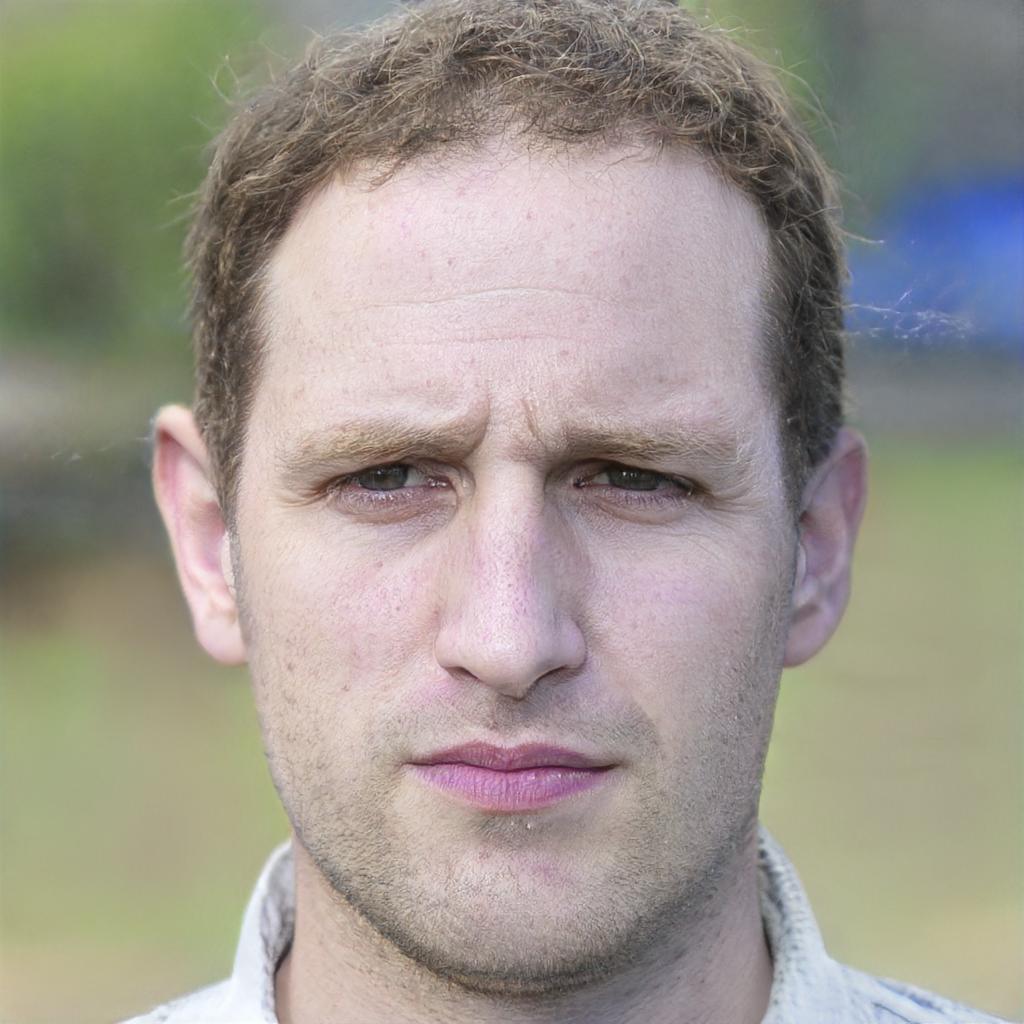

vidya:


In [ ]:
from IPython.display import Image, display
from IPython.display import HTML
from base64 import b64encode

# re do it in a nice way
print('result:')
display(Image(f'{outdir}/out.png',width=512,height=512))

# rescale vidya to 512px and display
print('vidya:')
vidya = f'{outdir}/out.mp4'
mangles = f'{outdir}/out512px.mp4'
os.system(f"ffmpeg -y -i {vidya} -vcodec libx264 {mangles}")
mp4 = open(mangles,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

